In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2|

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tf_util.systems import system_from_str
from train_dsn import train_dsn
import seaborn as sns
import pandas as pd

from util import fct_integrals as integrals
from util import tf_integrals as tf_integrals

from util import fct_mf as mf



In [2]:
### Set parameters

Mm = 3.5      # Mean of m
Mn = 1.       # Mean of n
Mi = 0.       # Mean of I

Sim = 1.      # Std of m
Sin = 1.      # Std of n
Sip = 1.      # Std of input orthogonal to m and n, along h (see Methods)

g = 0.8
tol = 1e-10;

Sini_min = 1e-4
Sini_max = 2.
num_vals = 40;
Sini_values = np.linspace(Sini_min, Sini_max, num_vals)

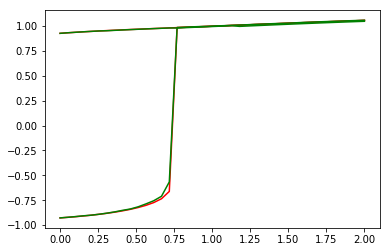

[[10. 10. 10. 10. 10. 10.  9.  9.  9.  9.  9.  9.  9.  9.  9.  8.  8.  8.
   8.  8.  8.  8.  8.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
   7.  7.  7.  7.]
 [10. 10. 10. 10. 11. 11. 11. 11. 11. 12. 12. 12. 13. 15.  9. 21. 18. 16.
  15. 15. 14. 14. 13. 13. 13. 12. 12. 12. 12. 12. 12. 11. 11. 11. 11. 11.
  11. 11. 11. 11.]]


In [17]:
ics_0 = np.array([5., 5., 5.], np.float64);
ics_1 = np.array([-5., 5., -5.], np.float64);
eps = 0.2;
eps_approx = 0.8;
tol_approx = .01;

Ks_valid = np.zeros((2,num_vals));
Ks_approx = np.zeros((2,num_vals));
count_approx = np.zeros((2,num_vals));
for i in range(num_vals):
    Sini = Sini_values[i];
    ParVec = [Mm, Mn, Mi, Sim, Sin, Sini, Sip];
    
    ys, count = mf.SolveStatic(ics_0, g, ParVec, eps, tol);
    Ks_valid[0,i] = ys[-1,2];
    
    ys, count = mf.SolveStatic(ics_0, g, ParVec, eps_approx, tol_approx);
    Ks_approx[0,i] = ys[-1,2];
    count_approx[0,i] = count;
    
    ys, count = mf.SolveStatic(ics_1, g, ParVec, eps, tol);
    Ks_valid[1,i] = ys[-1,2];
    
    ys, count = mf.SolveStatic(ics_1, g, ParVec, eps_approx, tol_approx);
    Ks_approx[1,i] = ys[-1,2];
    count_approx[1,i] = count;
    
    
    
plt.figure();
plt.plot(Sini_values, Ks_valid.T, 'r');
plt.plot(Sini_values, Ks_approx.T, 'g');
plt.show();

print(count_approx);



In [4]:
K = 1;
M = 10;


In [16]:
import tensorflow as tf

Mm = 3.5      # Mean of m
Mn = 1.       # Mean of n
Mi = 0.       # Mean of I

Sim = 1.      # Std of m
Sin = 1.      # Std of n
Sip = 1.      # Std of input orthogonal to m and n, along h (see Methods)

Sini = 1e-4;

Mm_tf = tf.get_variable('m', shape=(K,M,1), dtype=tf.float64);
Sini_tf = tf.get_variable('Sini', shape=(K,M,1,), dtype=tf.float64);

ValueError: Variable m already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-5-4ce77c4310bd>", line 13, in <module>
    Mm_tf = tf.get_variable('m', shape=(K,M,1,), dtype=tf.float64);
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):


In [11]:
Ics_0 = np.tile(np.expand_dims(np.expand_dims(ics_0, 0), 1), [K,M,1]);
Ics_1 = np.tile(np.expand_dims(np.expand_dims(ics_1, 0), 1), [K,M,1]);

T = 10;
def consistent_solve(y, g, ParVec, eps, T):
    Mm, Mn, Mi, Sim, Sin, Sini, Sip = ParVec
    y_1 = y[:,:,0];
    y_2 = y[:,:,1];
    y_3 = y[:,:,2];

    for i in range(T):
        Sii = tf.sqrt((Sini/Sin)**2 + Sip**2);
        
        mu = Mm * y_3 + Mi
        new1 = g*g * tf_integrals.PhiSq(mu, y_2) + Sim**2 * y_3**2 + Sii**2
        new2 =  Mn * tf_integrals.Phi(mu, y_2) + Sini * tf_integrals.Prime(mu, y_2)

        y_new_1 = Mm * new2 + Mi
        y_new_2 = (1-eps)*y_2 + eps*new1
        y_new_3 = (1-eps)*y_3 + eps*new2

        y_1 = y_new_1;
        y_2 = y_new_2;
        y_3 = y_new_3;

    y_out = tf.stack([y_1, y_2, y_3], axis=0);
    return y_out;

Sini = 1e-4;
ParVec = Mm_tf[:,:,0], Mn, Mi, Sim, Sin, Sini_tf[:,:,0], Sip;
sol = consistent_solve(Ics_0, g, ParVec, eps, T);


In [15]:
_Mm = np.random.normal(0,1,(K,M,1));
_Sini = np.random.normal(0,1,(K,M,1));
feed_dict = {Mm_tf:_Mm, Sini_tf:_Sini};

dsoldphi = tf.gradients(sol, [Mm_tf,Sini_tf]);
sess = tf.Session();
_dsoldphi = sess.run(dsoldphi, {Mm_tf:_Mm, Sini_tf:_Sini});
